# HOPP Example 05: Hybrid Plant with Heuristic Battery Dispatch for a Constant Power Load at a different site
Looks at a 100 MW plant (interconnection), with 100 MW of installed wind and 100 MW of installed solar and a 50 MW battery.  The plant site is located at an example site in the wind corridor located in Kansas.  In this case, a heuristic load-following battery dispatch is used, which follows the given loading without any forecasting or optimization.



In [1]:
import sys
import os
from pathlib import Path
import json
from pathlib import Path
import pandas as pd
import numpy as np
sys.path.append('')

from hybrid.sites import SiteInfo
from hybrid.sites import flatirons_site as sample_site
from hybrid.hybrid_simulation import HybridSimulation
from hybrid.log import hybrid_logger as logger
from hybrid.keys import set_nrel_key_dot_env
from hybrid.dispatch.plot_tools import plot_battery_output, plot_battery_dispatch_error, plot_generation_profile


examples_dir = Path("examples")

# Set API key
set_nrel_key_dot_env()

/mnt/c/Users/gstarke/Documents/Research_Programs/HOPP/HOPP/log/hybrid_systems_2023-01-23T17.12.57.377007.log


## Setting the plant characteristics

In [2]:
# Set characteristics of the system - NREL Flatirons site 

# Set wind, solar, and interconnection capacities (in MW)
solar_size_mw = 100
wind_size_mw = 100
battery_capacity_mw = 50
interconnection_size_mw = 100

technologies = {
    'pv': {
        'system_capacity_kw': solar_size_mw * 1000,
    },
    'wind': {
        'num_turbines': 25,
        'turbine_rating_kw': int(wind_size_mw * 1000 / 25)
    },
    'battery': {
        'system_capacity_kwh': battery_capacity_mw * 4 *1000,
        'system_capacity_kw': battery_capacity_mw * 1000
    }
}

baseload_limit_kw = float(30 * 1000)
baseload_percent = 95.0
dispatch_options = {'battery_dispatch': 'baseload_heuristic', 'grid_charging': False, 'use_baseload' :True,\
        'baseload':{'limit':baseload_limit_kw, 'compliance_factor': baseload_percent}}

## Loading the resource and site data

In [3]:
# Load the resource information

# Resource inputs for ~ Garden City, KS (good midpoint between wind and solar)
lat = 38.0 
lon = -100.8
elev = 2838

year = 2013
sample_site['year'] = year
sample_site['lat'] = lat
sample_site['lon'] = lon
sample_site['elev'] = elev


prices_file = examples_dir.parent / "resource_files" / "grid" / "pricing-data-2015-IronMtn-002_factors.csv"
site = SiteInfo(sample_site, grid_resource_file=prices_file)

## Running the hybrid plant
Note: this cell will take some time to run (a few minutes), since it's running optimized battery dispatch over the whole year

In [4]:
# Create model
hybrid_plant = HybridSimulation(technologies, site, interconnect_kw=interconnection_size_mw * 1000,\
                        dispatch_options=dispatch_options)

# Adjust some inptus to the model 
hybrid_plant.pv.dc_degradation = (0,)             # year over year degradation
hybrid_plant.wind.wake_model = 3                # constant wake loss, layout-independent
hybrid_plant.wind.value("wake_int_loss", 3)     # percent wake loss

hybrid_plant.pv.system_capacity_kw = solar_size_mw * 1000
hybrid_plant.wind.system_capacity_by_num_turbines(wind_size_mw * 1000)

# prices_file are unitless dispatch factors, so add $/kwh here
hybrid_plant.ppa_price = 0.04

# use single year for now, multiple years with battery not implemented yet
plant_life = 25
hybrid_plant.simulate(project_life=plant_life)


dispatch options:  {'battery_dispatch': 'baseload_heuristic', 'grid_charging': False, 'use_baseload': True, 'baseload': {'limit': 30000.0, 'compliance_factor': 95.0}}
Grid price [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Simulating system with dispatch optimization...
	 0 % complete
	 20 % complete
	 40 % complete
	 60 % complete
	 80 % complete
Percent of time firm power requirement is met:  92.64
Percent total firm power requirement is satisfied:  95.23


## Writing the outputs from the simulation

output after losses over gross output 0.8094133202751808
{"pv": 196632549.14659822, "wind": 290535239.8404715, "battery": -468143.0288255375, "hybrid": 467551674.27854633}
{"pv": -13204768.412531838, "wind": -32104276.34565647, "battery": -70397367.15615796, "hybrid": -123780301.59947515}


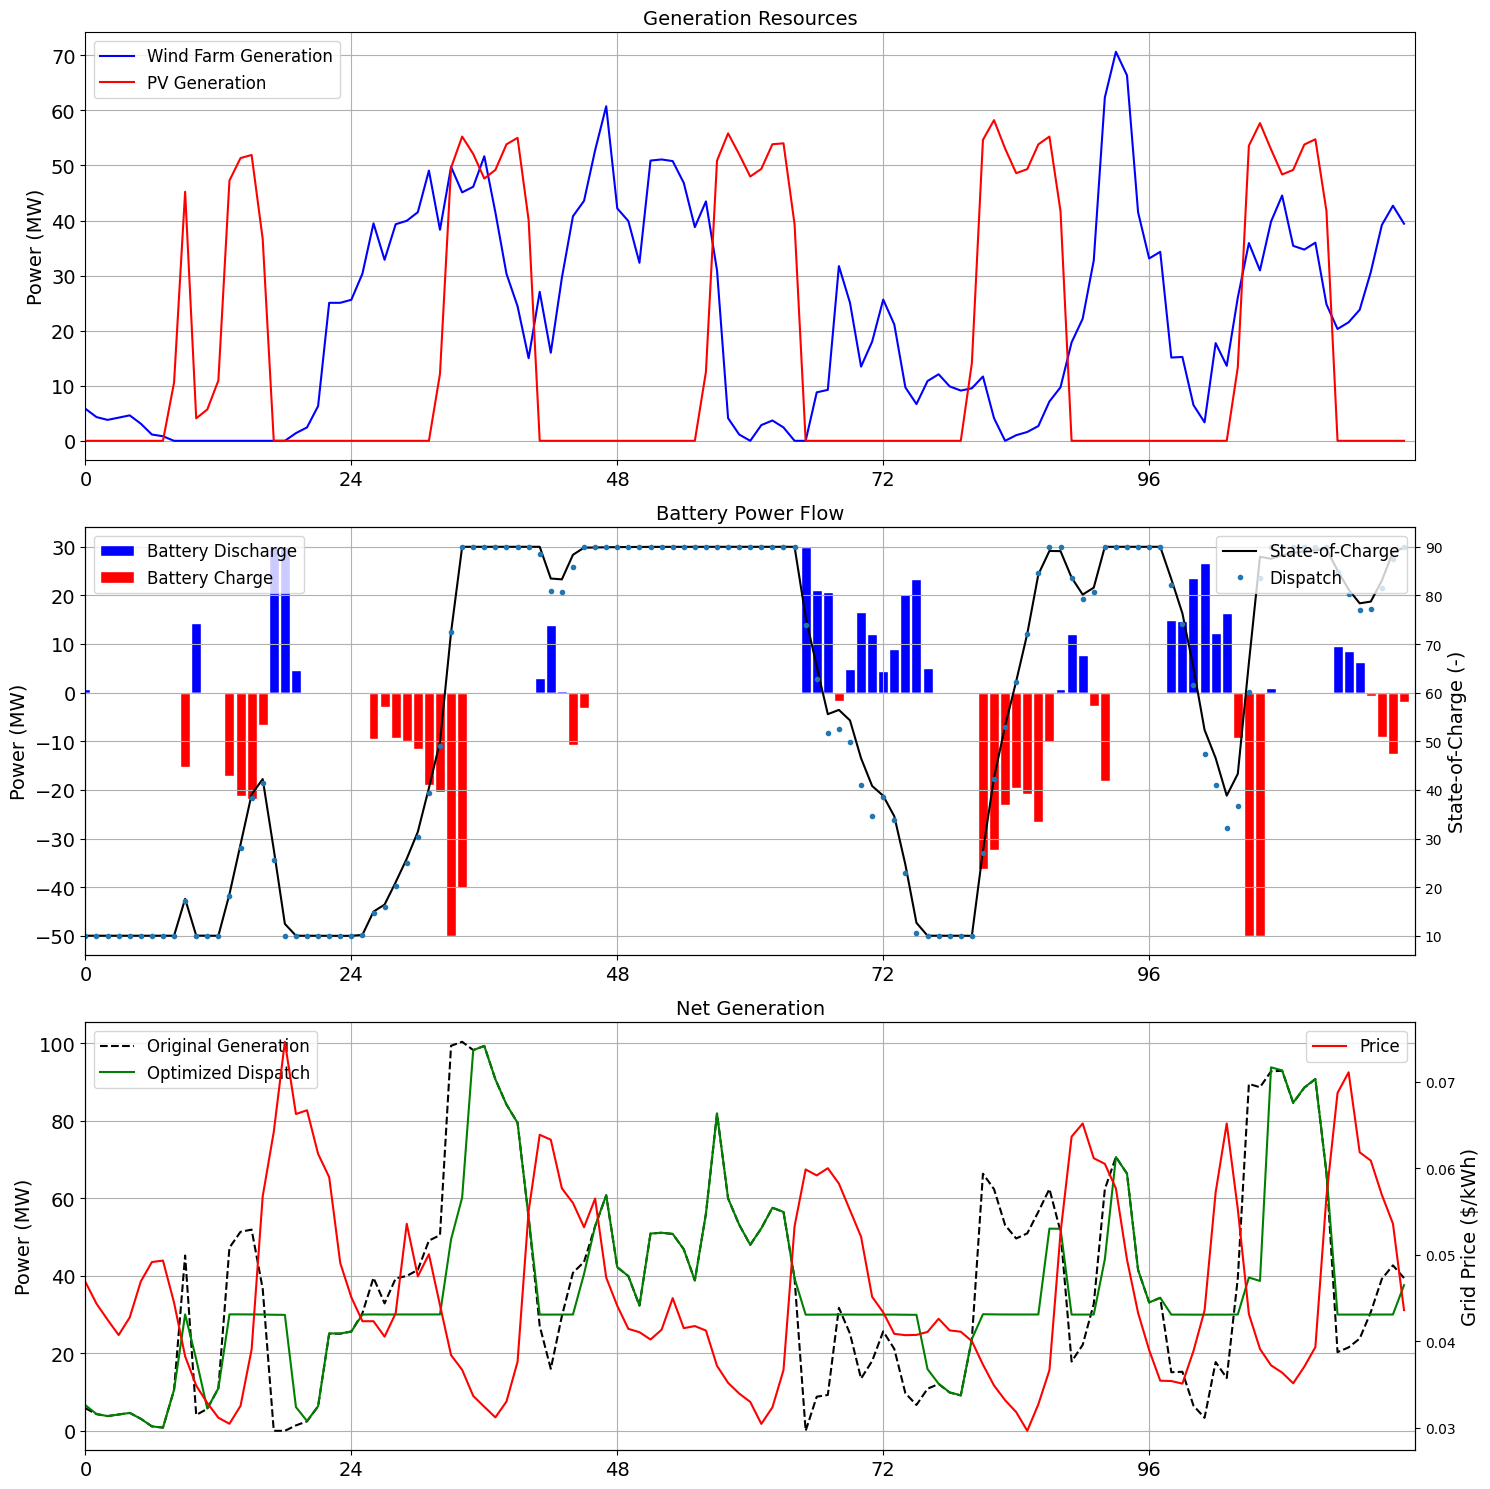

In [6]:

print("output after losses over gross output",
      hybrid_plant.wind.value("annual_energy") / hybrid_plant.wind.value("annual_gross_energy"))

# Save the outputs
annual_energies = hybrid_plant.annual_energies
npvs = hybrid_plant.net_present_values
revs = hybrid_plant.total_revenues
print(annual_energies)
print(npvs)
# print(revs)


file = 'figures/'
tag = 'simple2_'
#plot_battery_dispatch_error(hybrid_plant, plot_filename=file+tag+'battery_dispatch_error.png')
'''
for d in range(0, 360, 5):
    plot_battery_output(hybrid_plant, start_day=d, plot_filename=file+tag+'day'+str(d)+'_battery_gen.png')
    plot_generation_profile(hybrid_plant, start_day=d, plot_filename=file+tag+'day'+str(d)+'_system_gen.png')
'''
# plot_battery_dispatch_error(hybrid_plant)
# plot_battery_output(hybrid_plant)
plot_generation_profile(hybrid_plant)
#plot_battery_dispatch_error(hybrid_plant, plot_filename=tag+'battery_dispatch_error.png')
